# In this notebook:
## We present the model that employs GradientBoostingRegressor while creating relevant plots to visualize model learning and performance

Note: Be mindful of which city data you're feeding into this model (and checking whether it has lagged values present or not, since it's presence leads to high accuracy) and according to the city dataset size adjust the n_spilts for TimeSeriesSplit (5 splits for 1000+ rows and 10 for <1000)


Gradient Boosting - Fold 1
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Validation RMSE: 49.62
Validation MSE: 2462.58
Validation MAE: 38.93
R²: 0.79


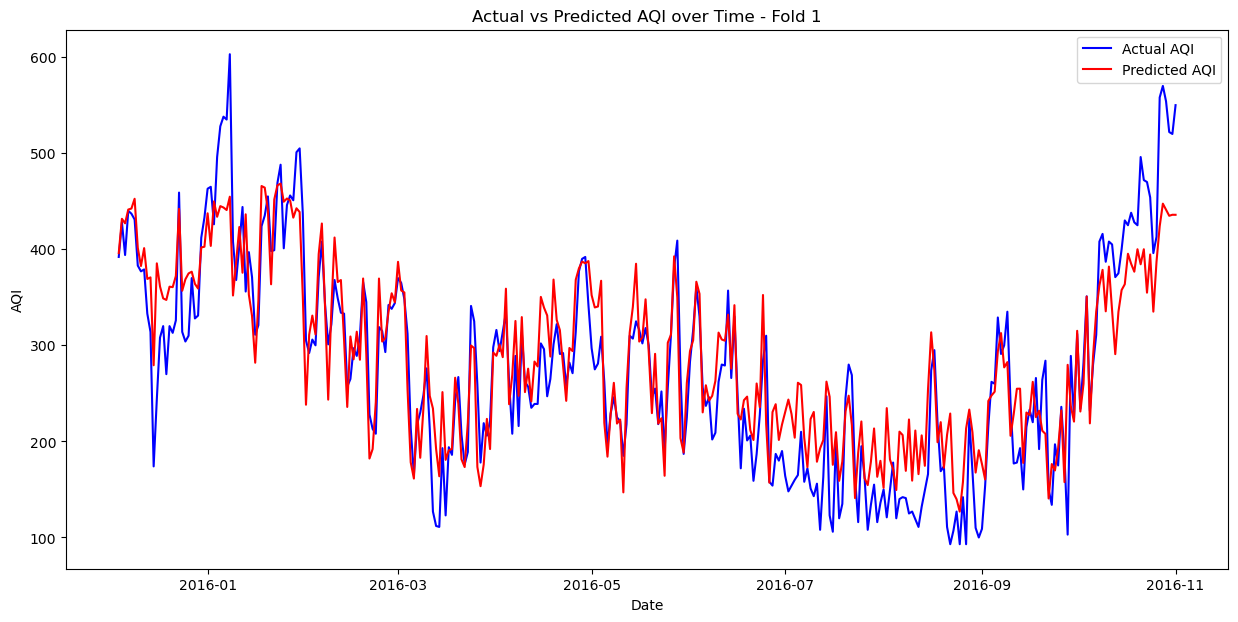

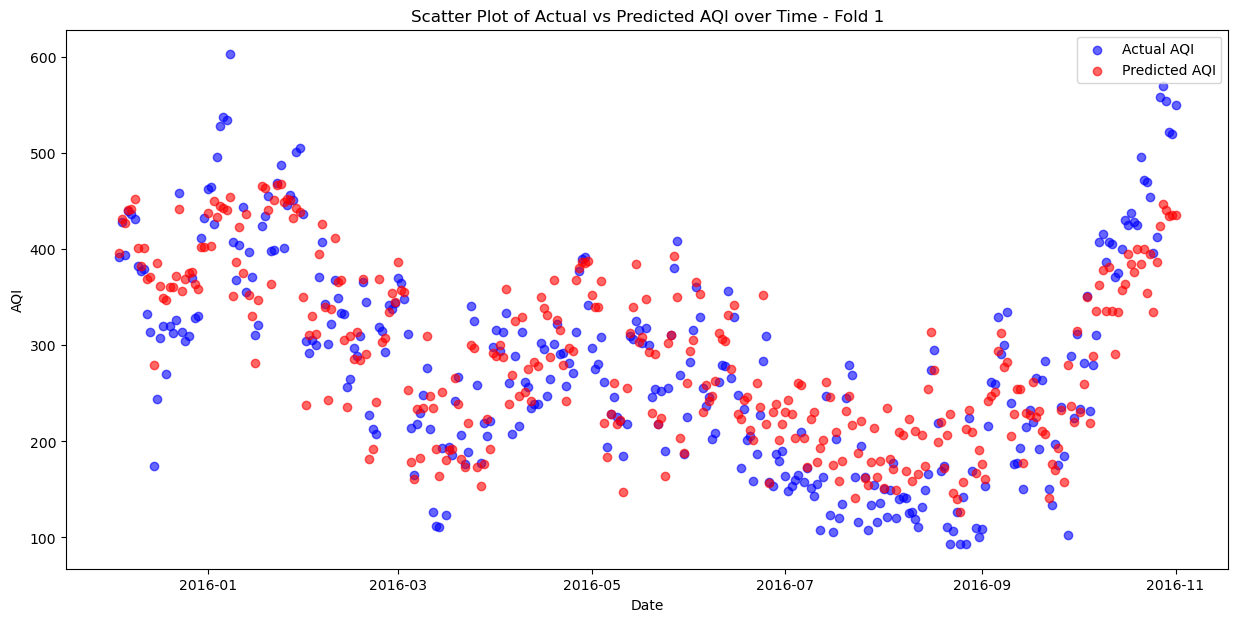

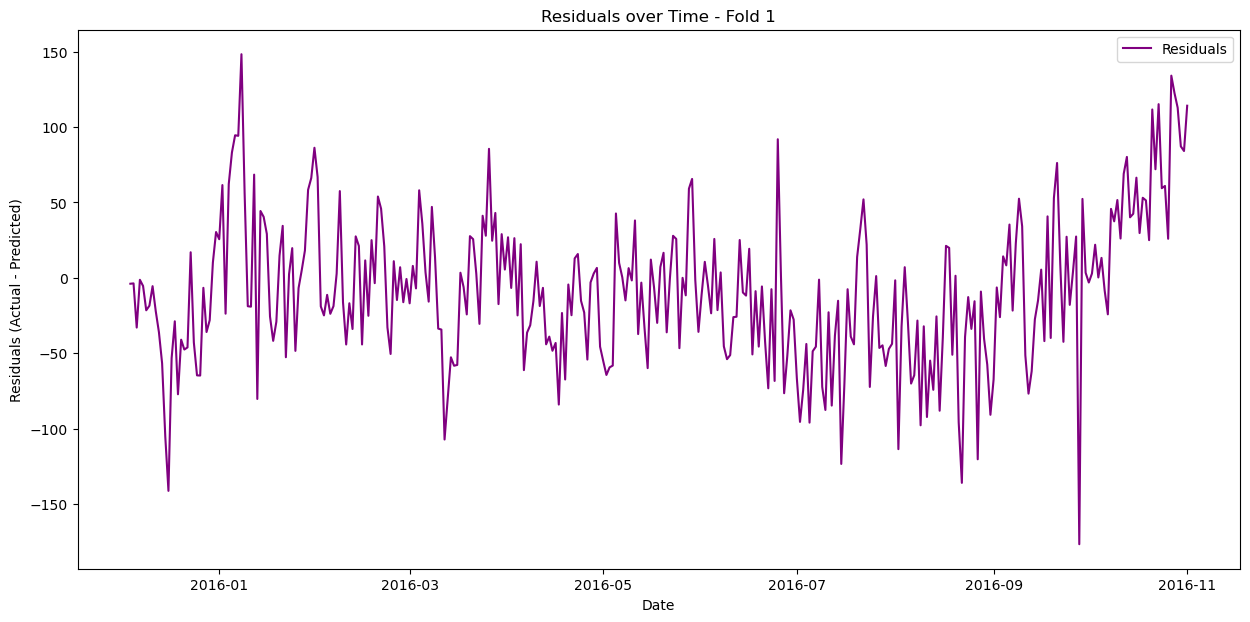

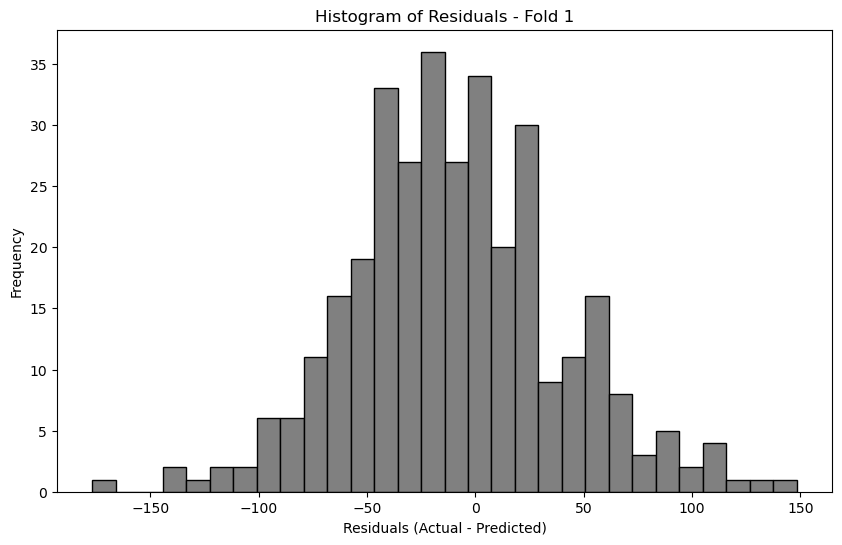

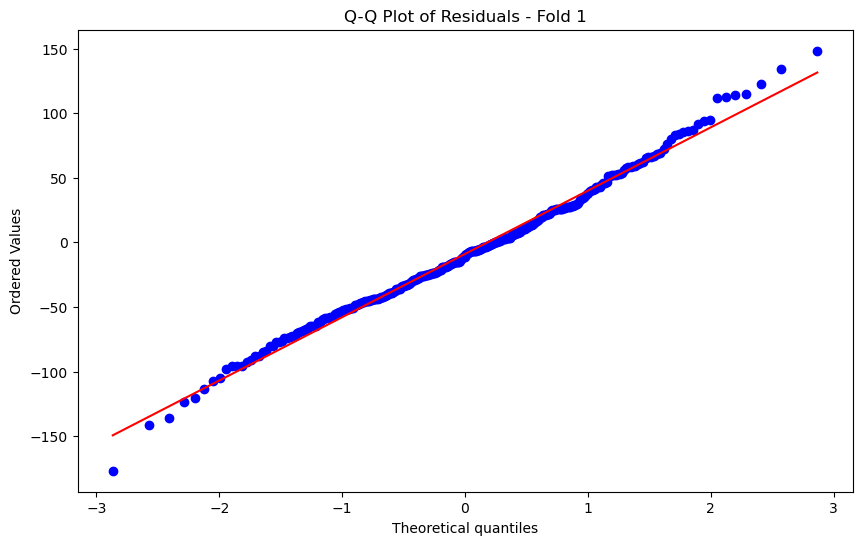

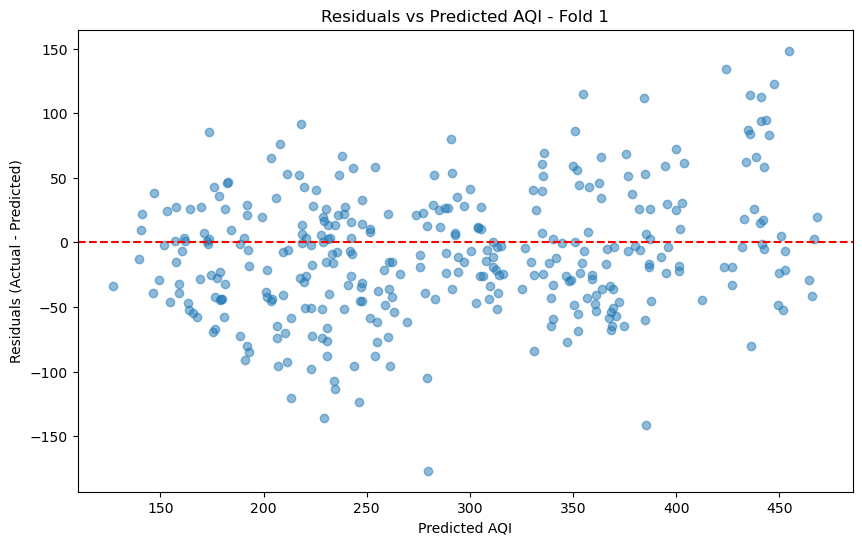


Gradient Boosting - Fold 2
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Validation RMSE: 62.83
Validation MSE: 3947.28
Validation MAE: 49.16
R²: 0.83


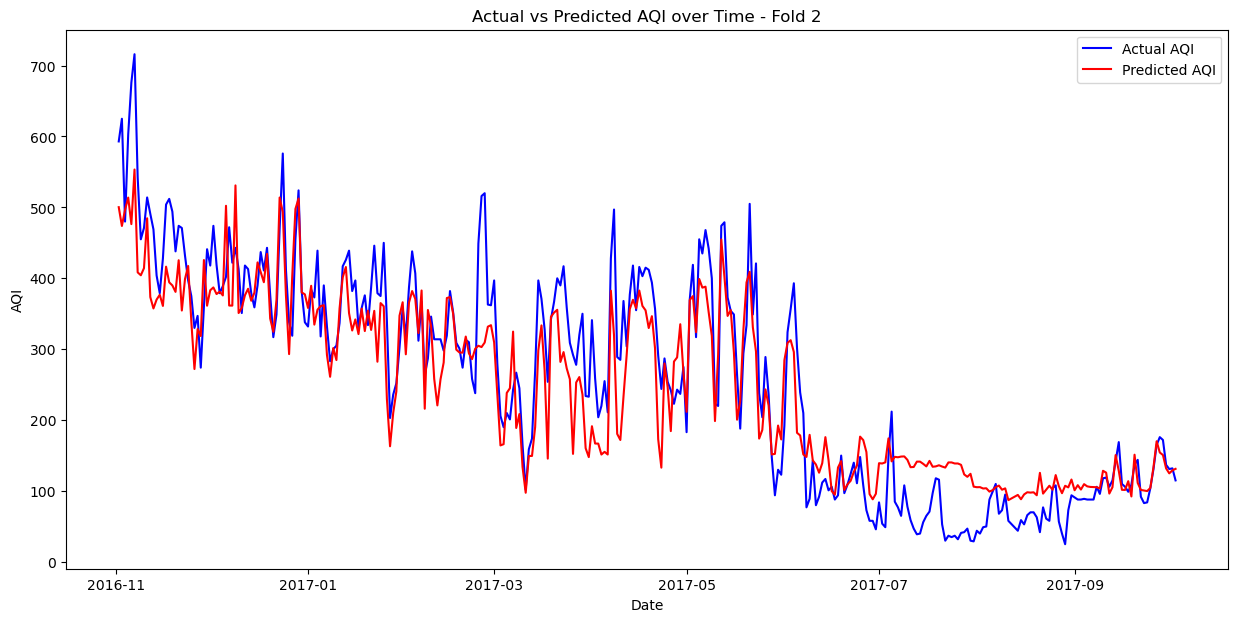

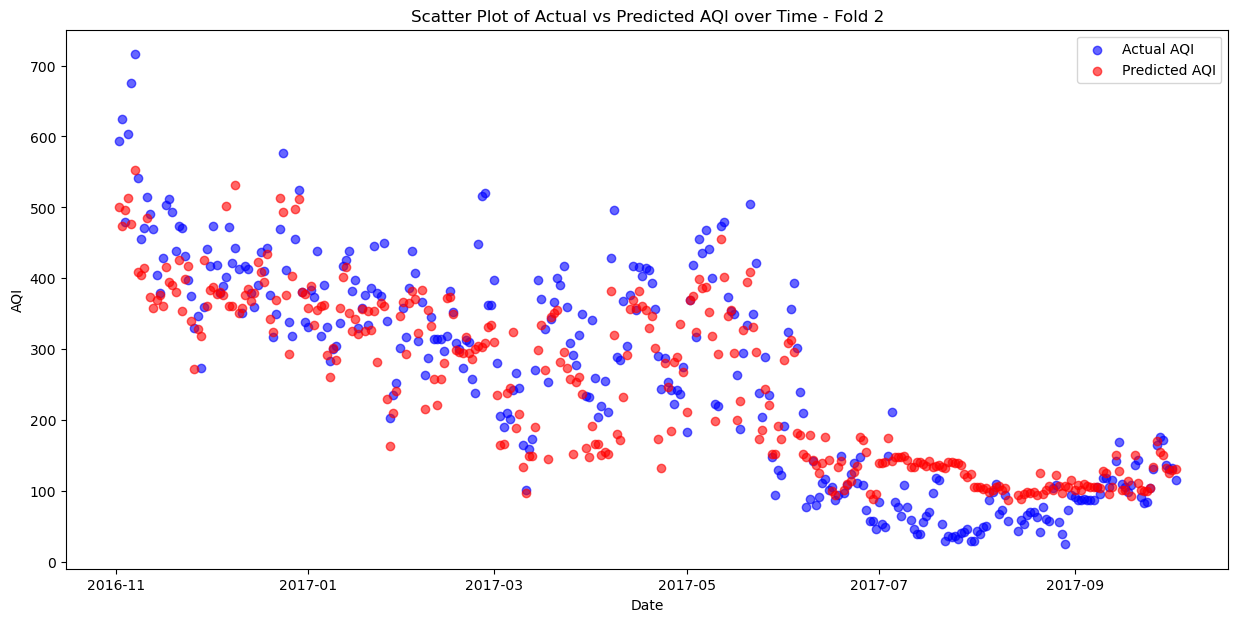

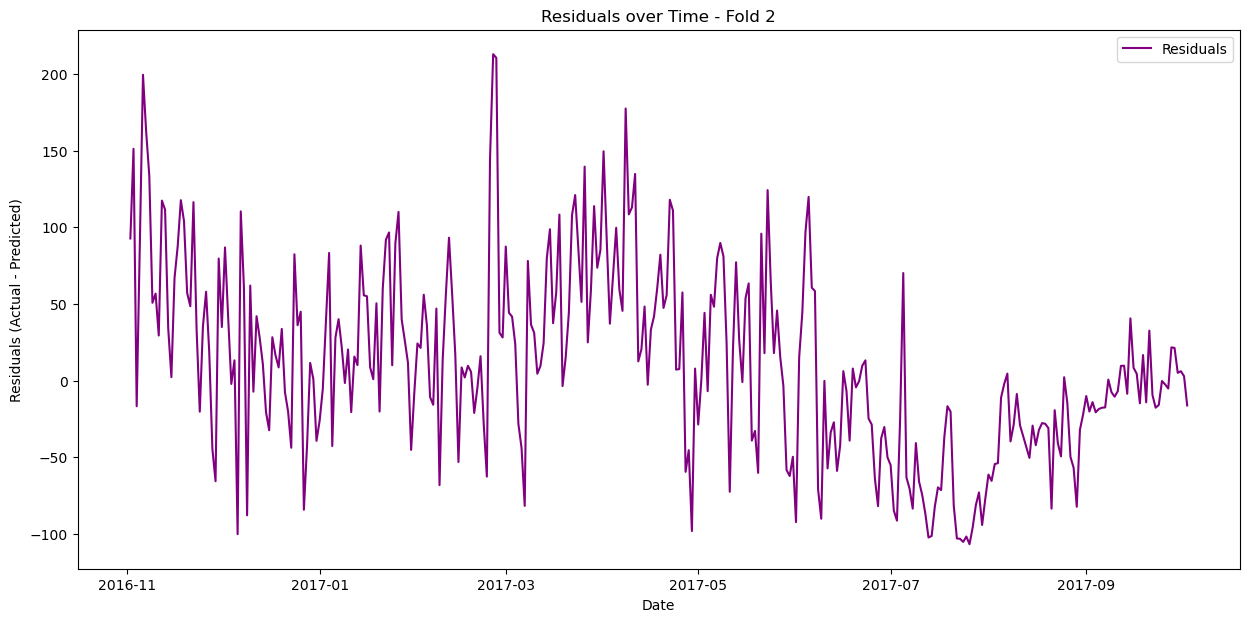

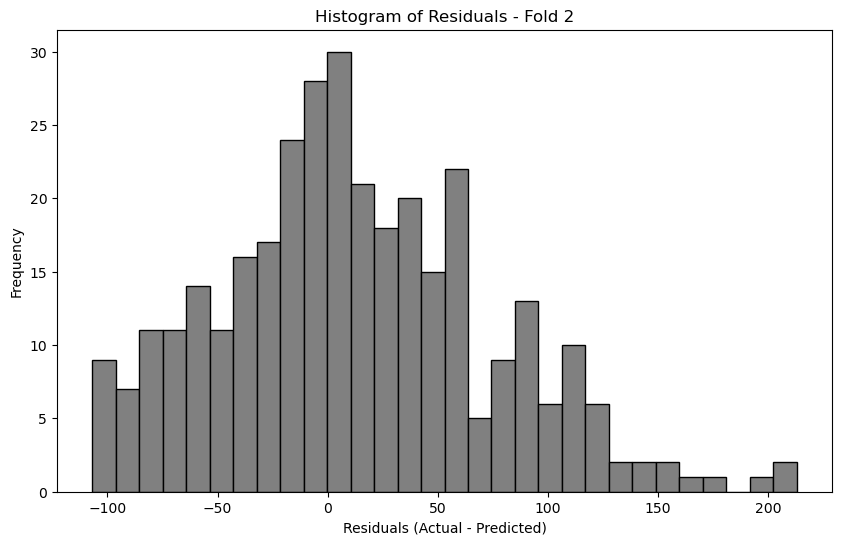

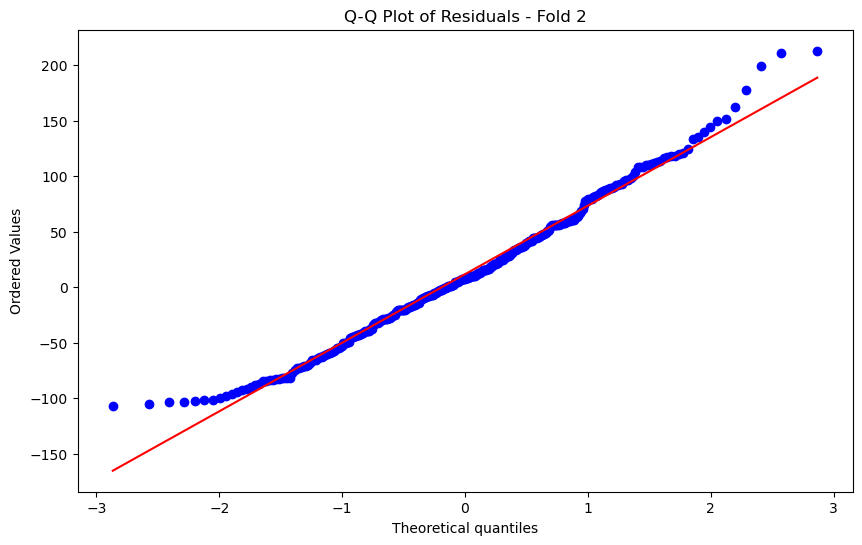

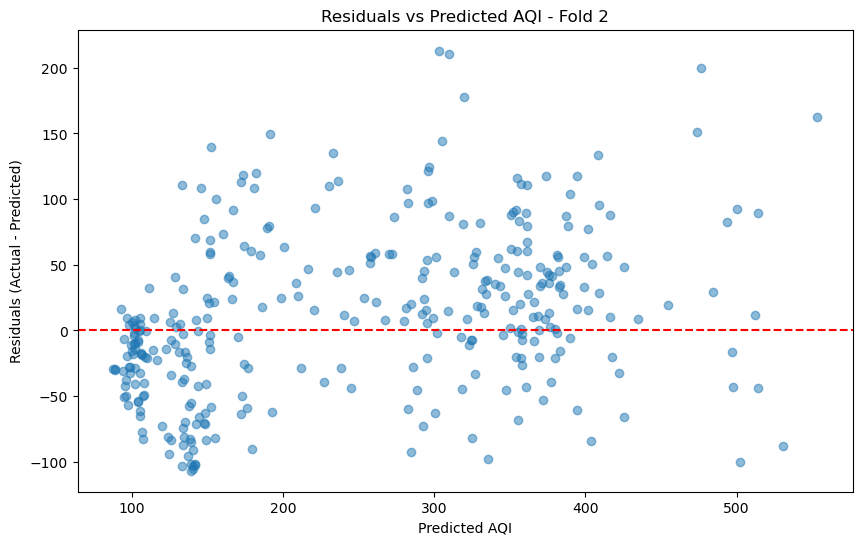


Gradient Boosting - Fold 3
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Validation RMSE: 37.35
Validation MSE: 1395.34
Validation MAE: 28.53
R²: 0.89


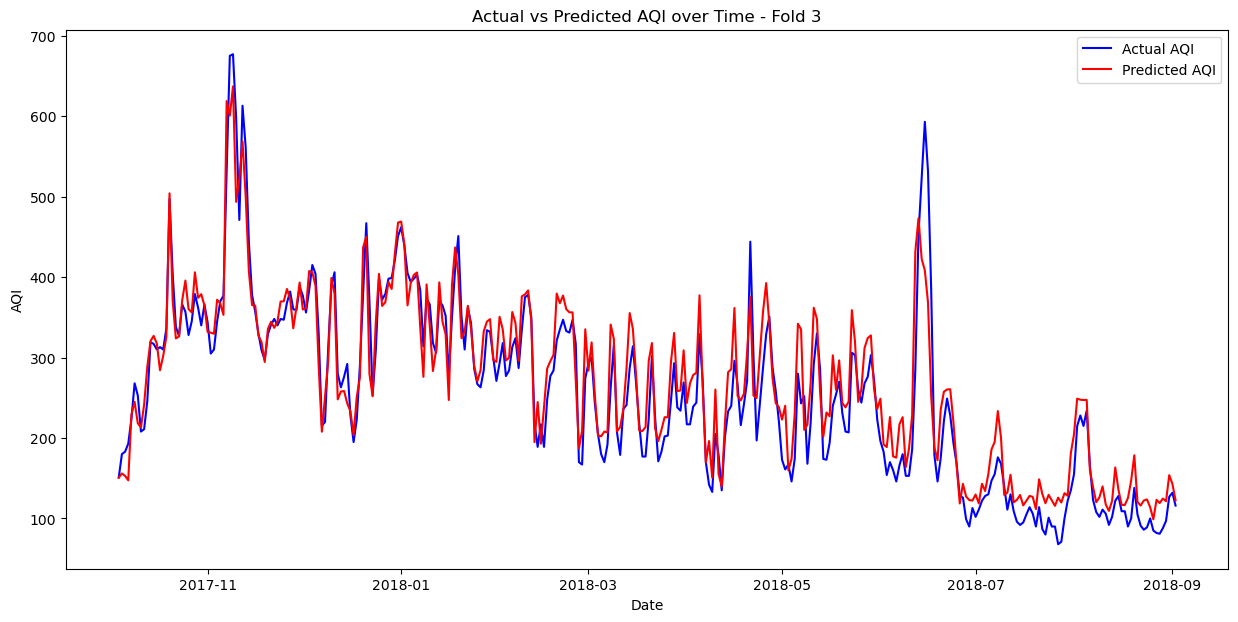

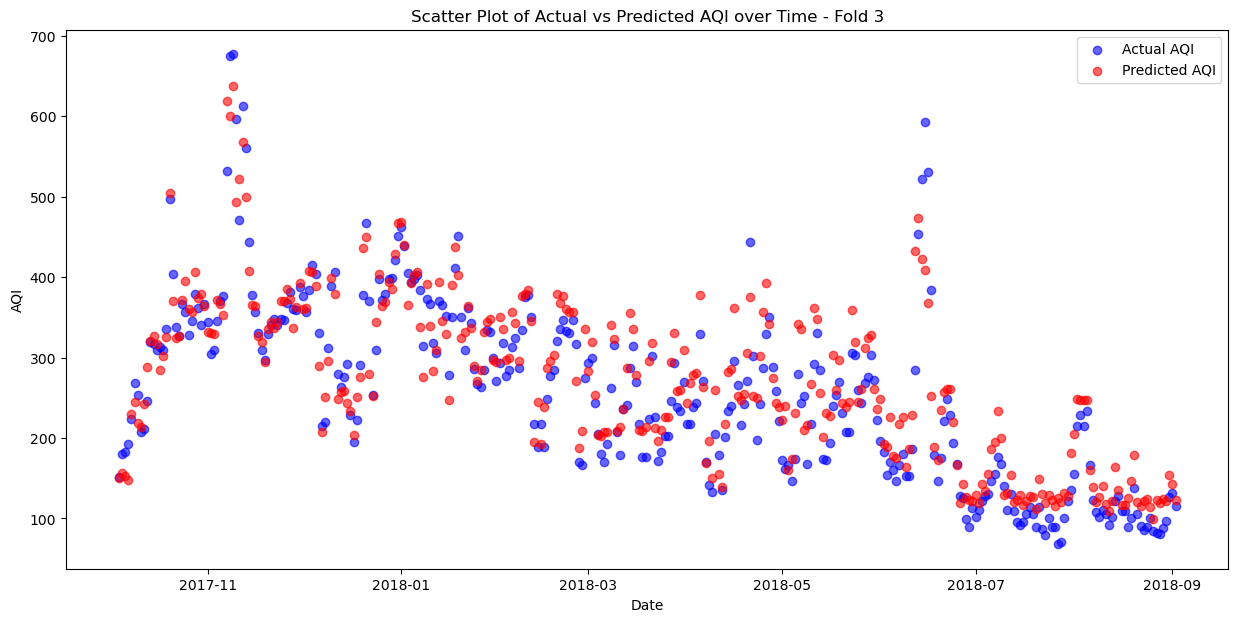

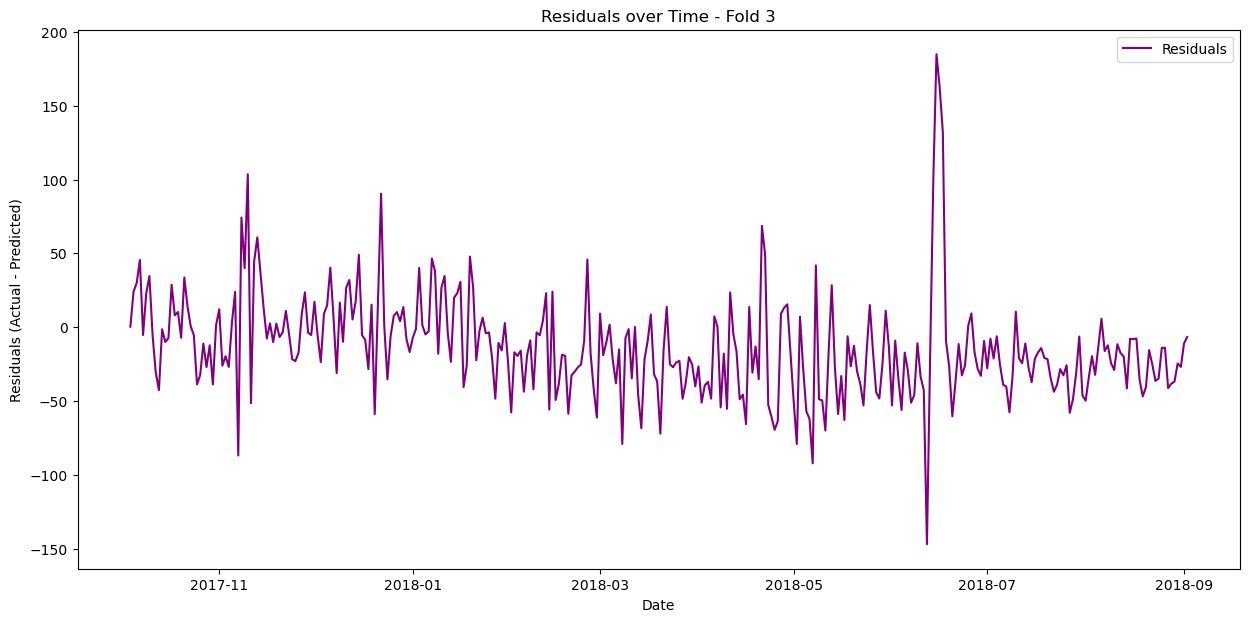

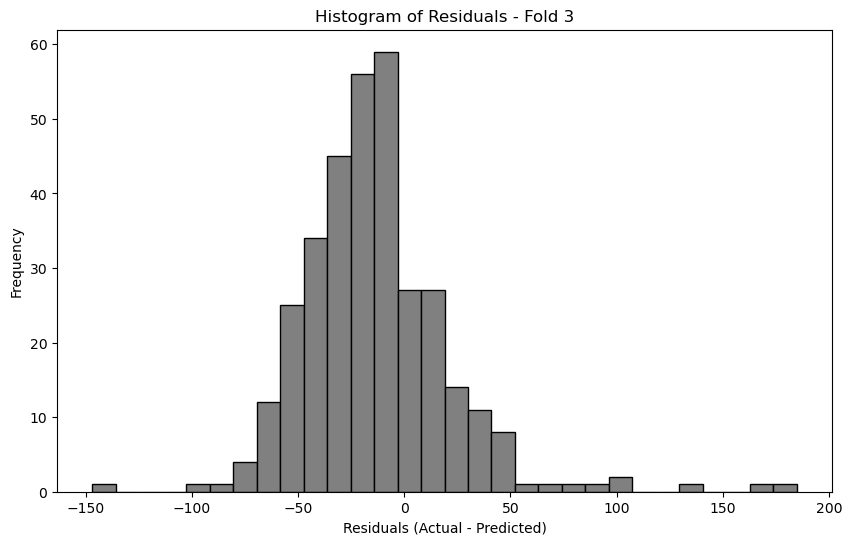

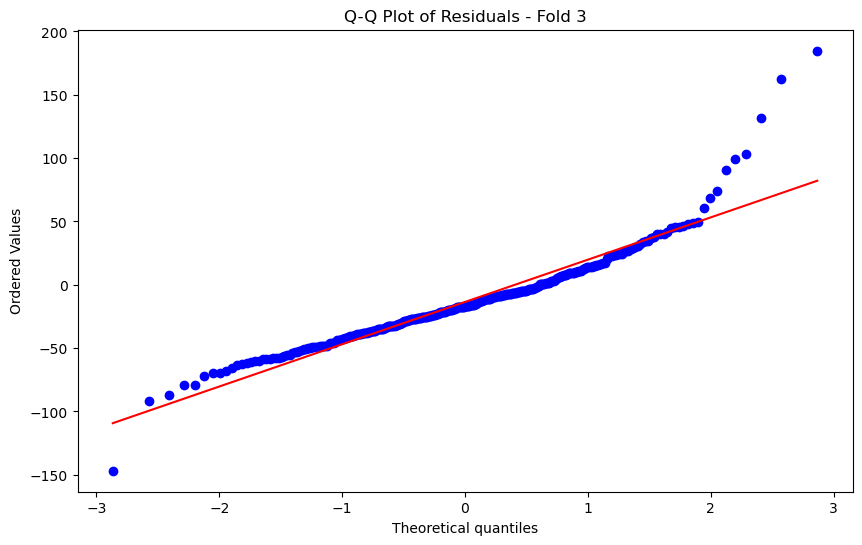

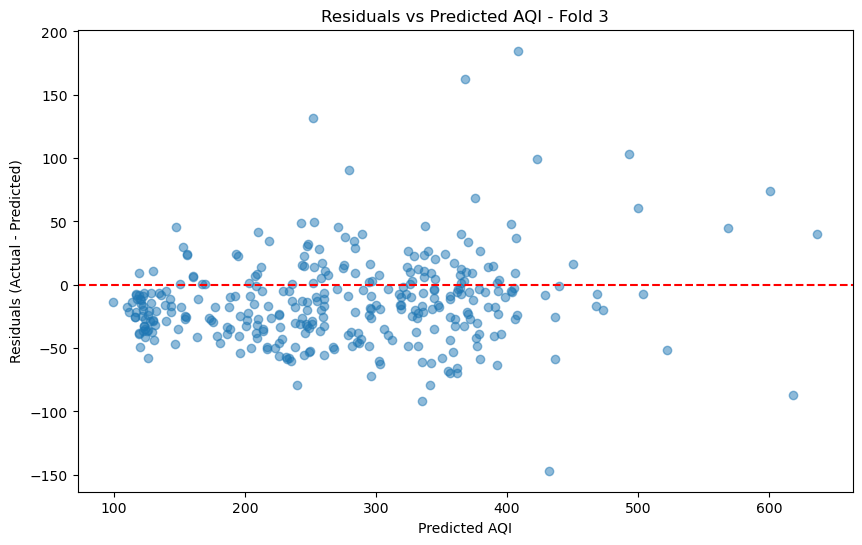


Gradient Boosting - Fold 4
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Validation RMSE: 32.06
Validation MSE: 1027.96
Validation MAE: 23.86
R²: 0.92


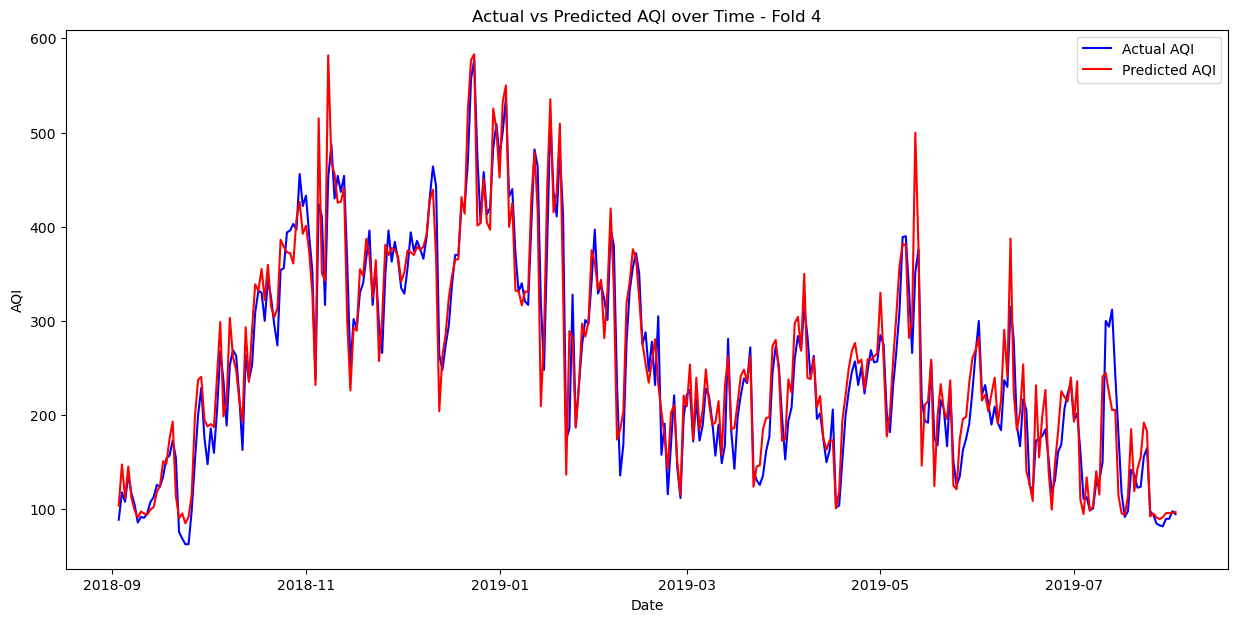

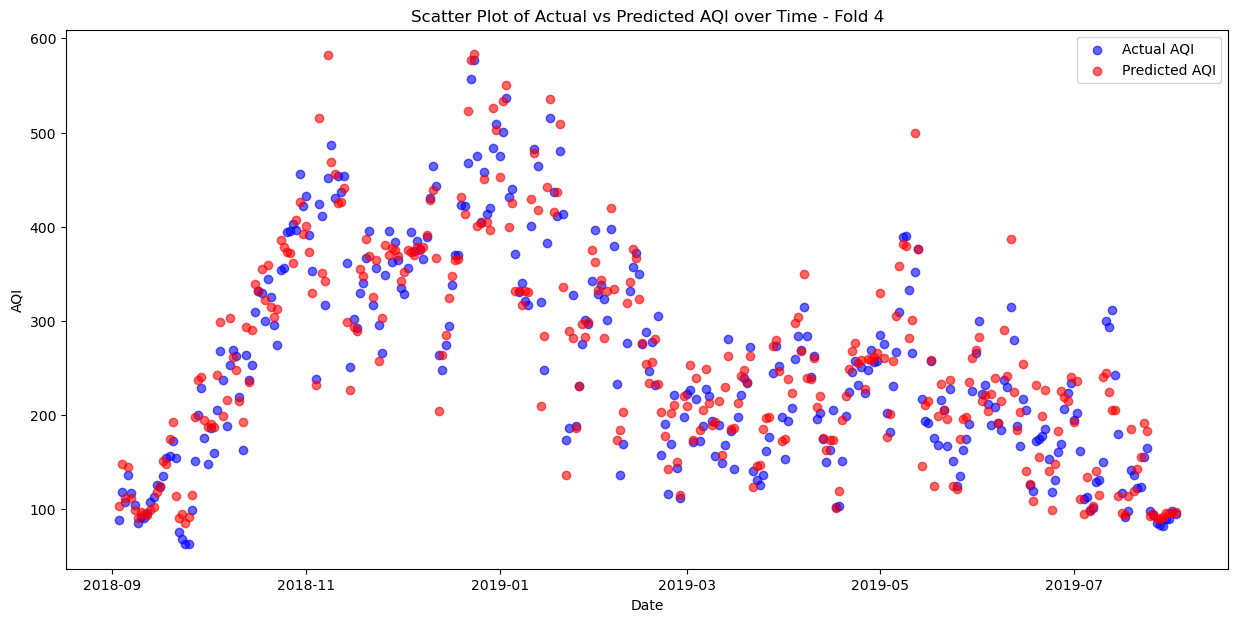

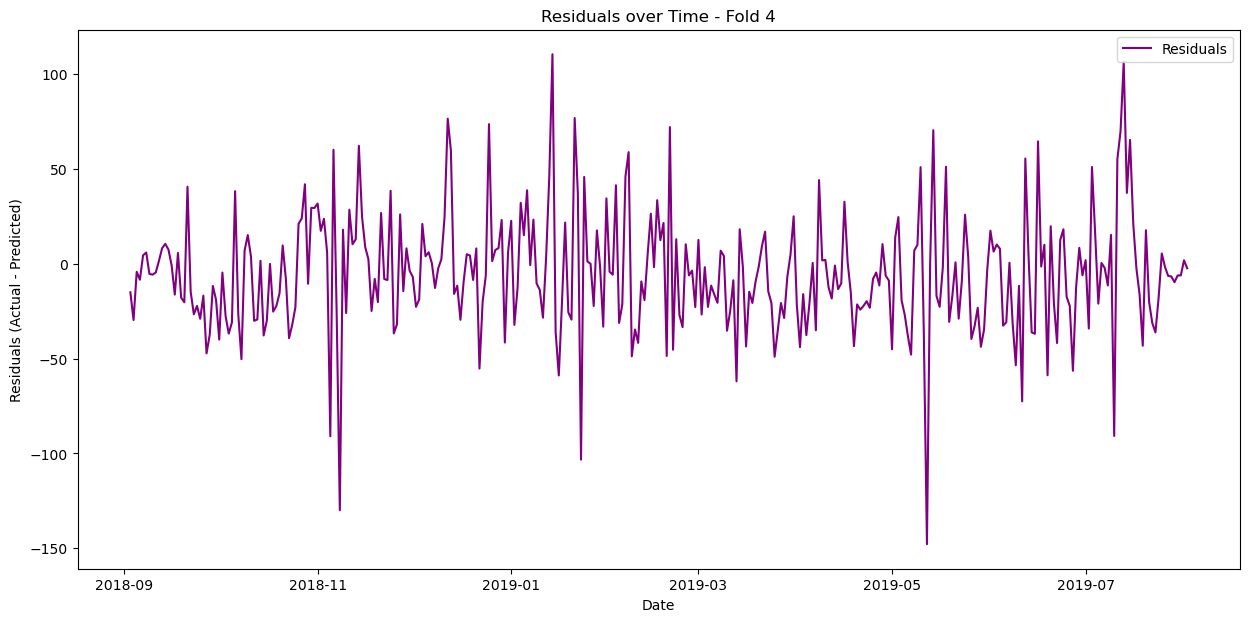

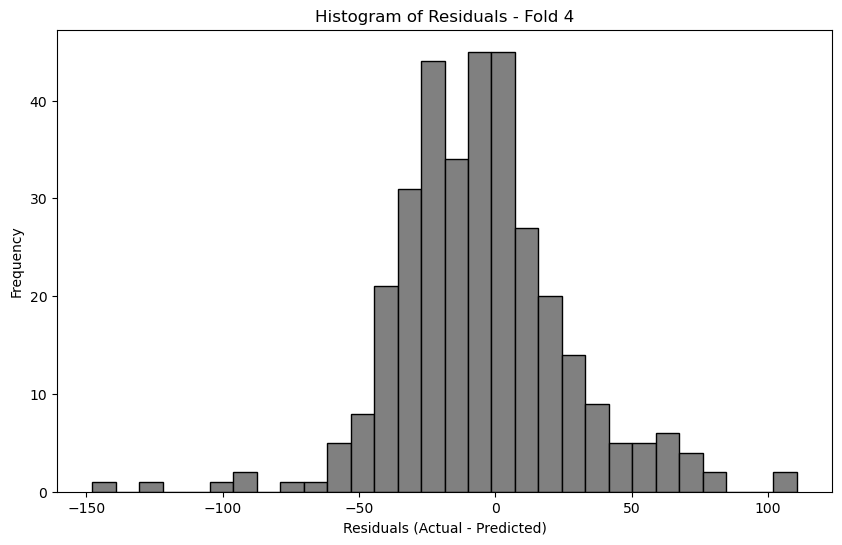

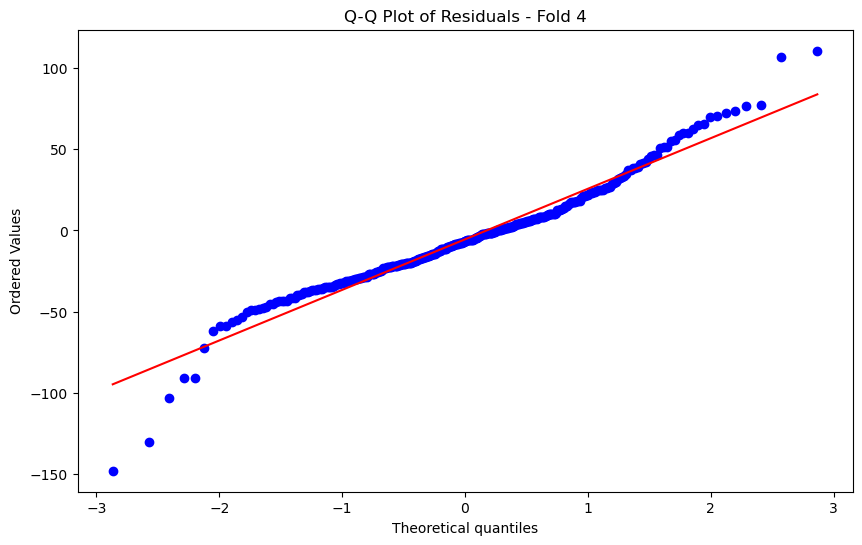

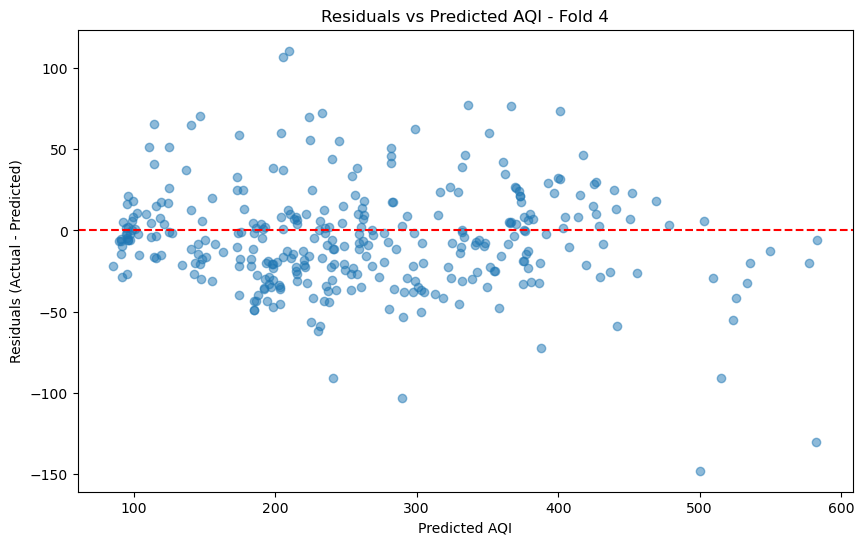


Gradient Boosting - Fold 5
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Validation RMSE: 26.96
Validation MSE: 726.78
Validation MAE: 20.76
R²: 0.95


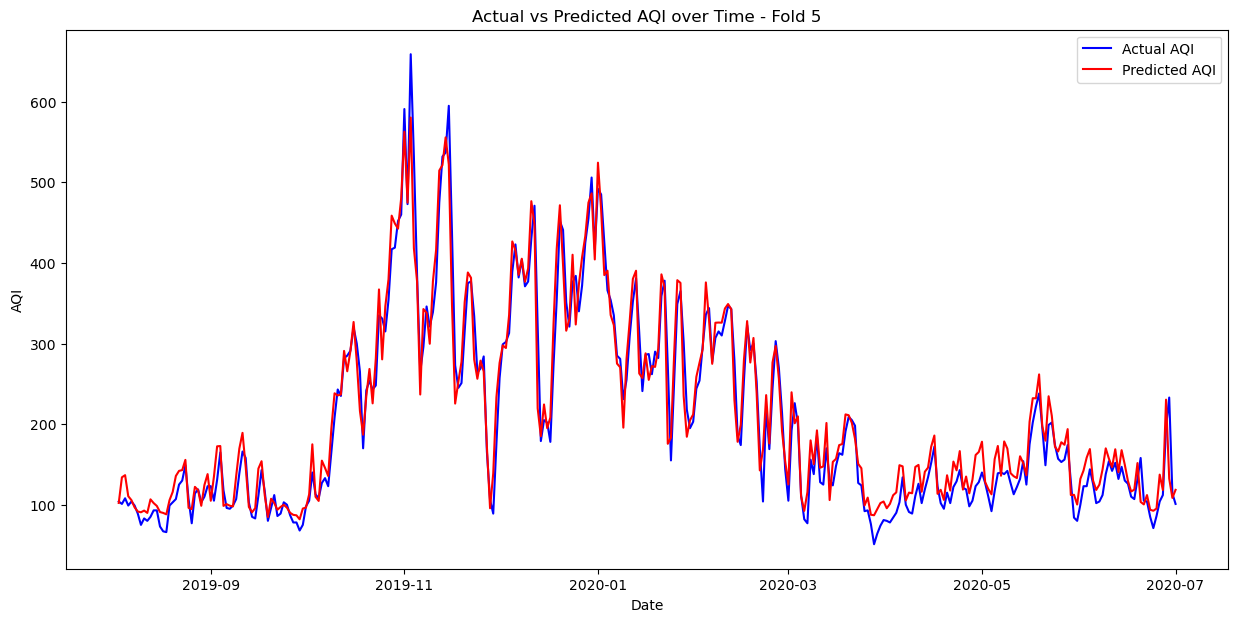

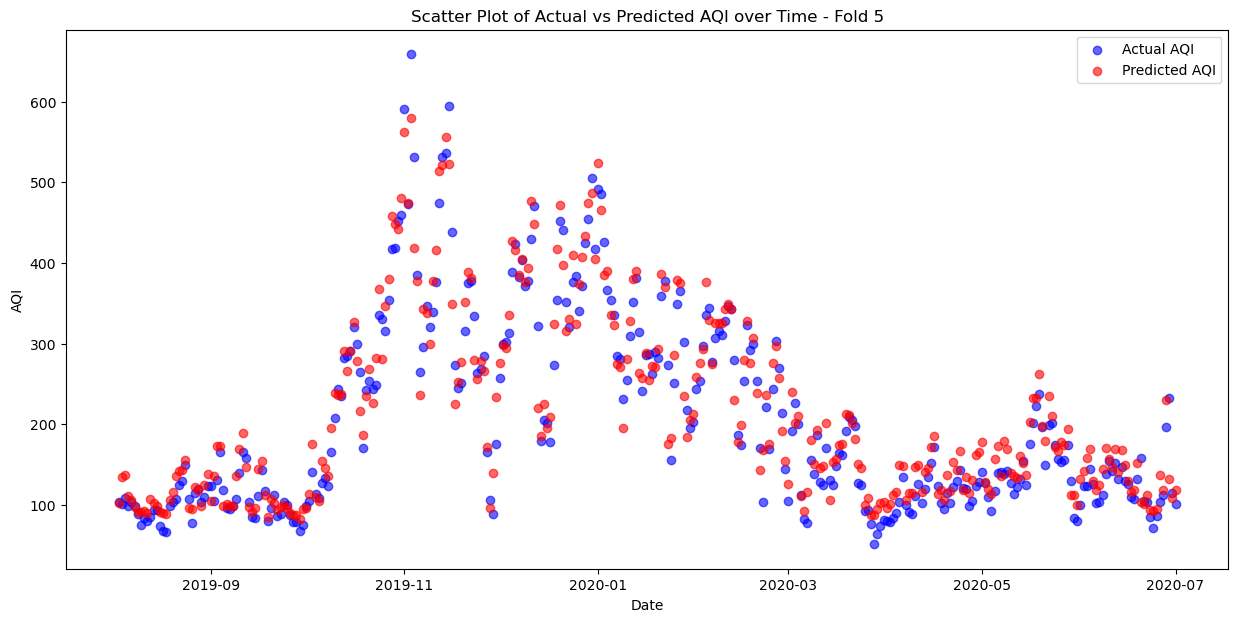

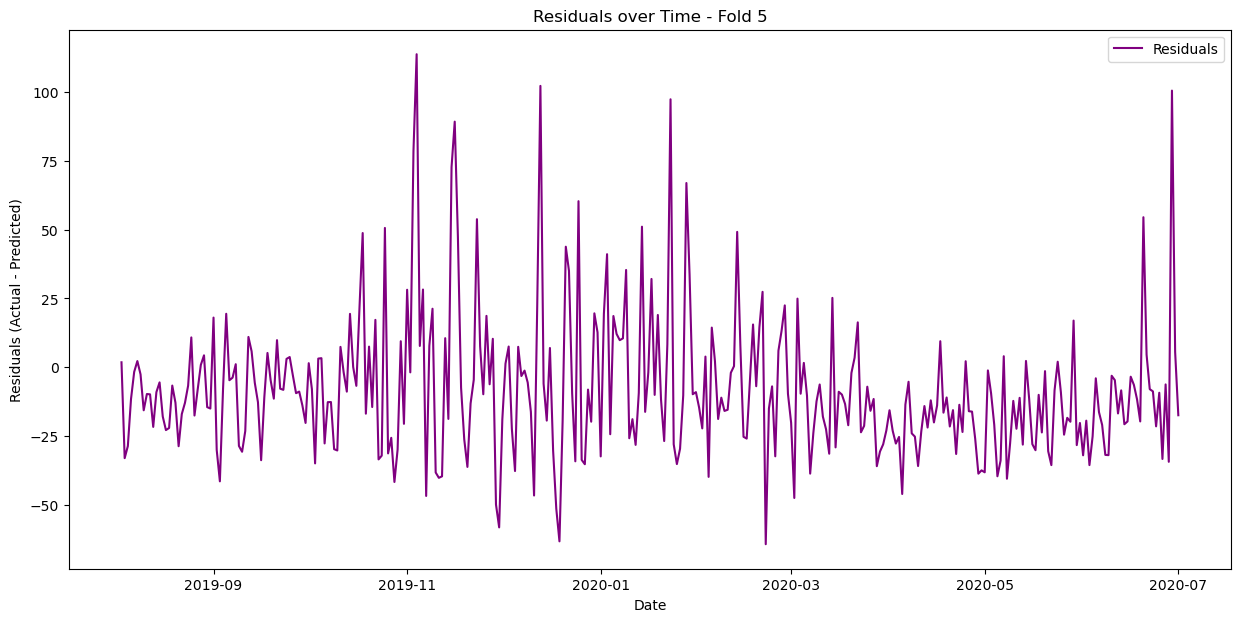

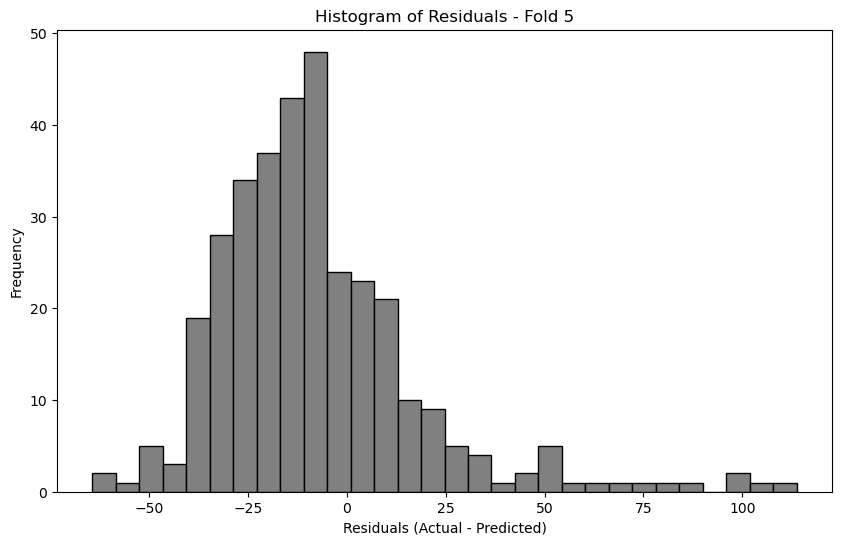

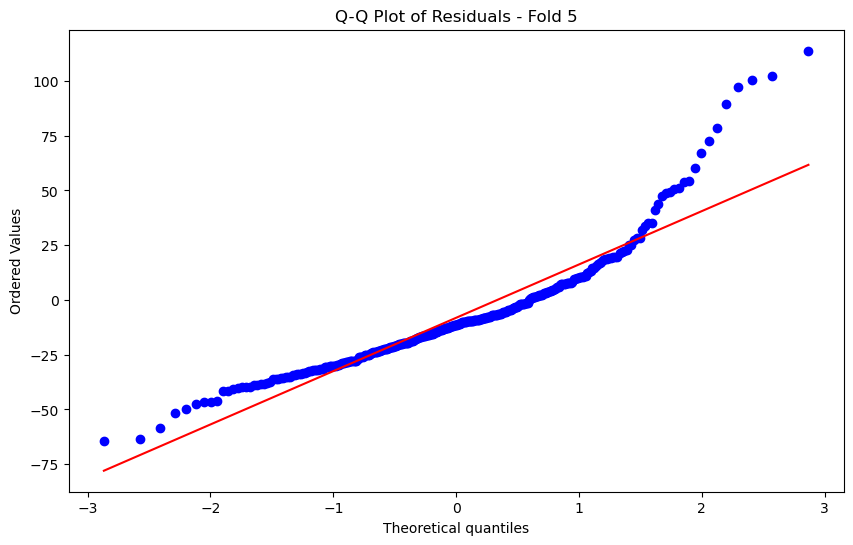

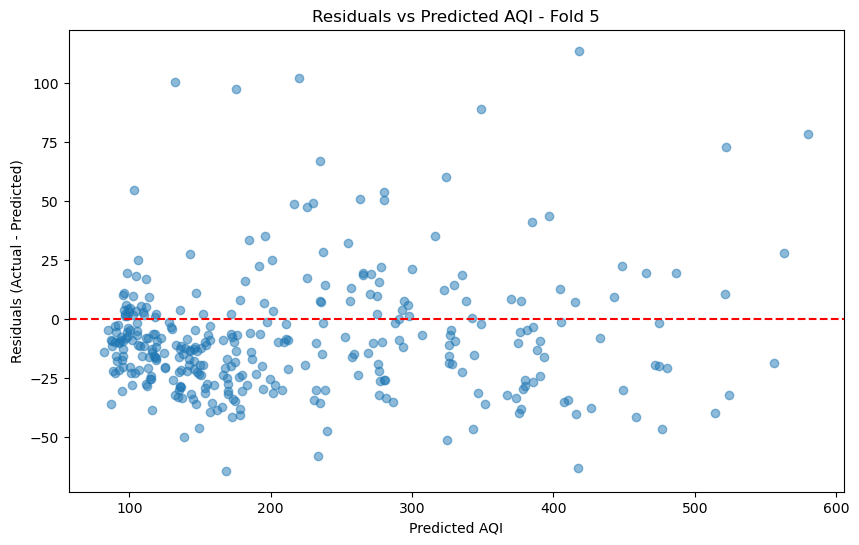

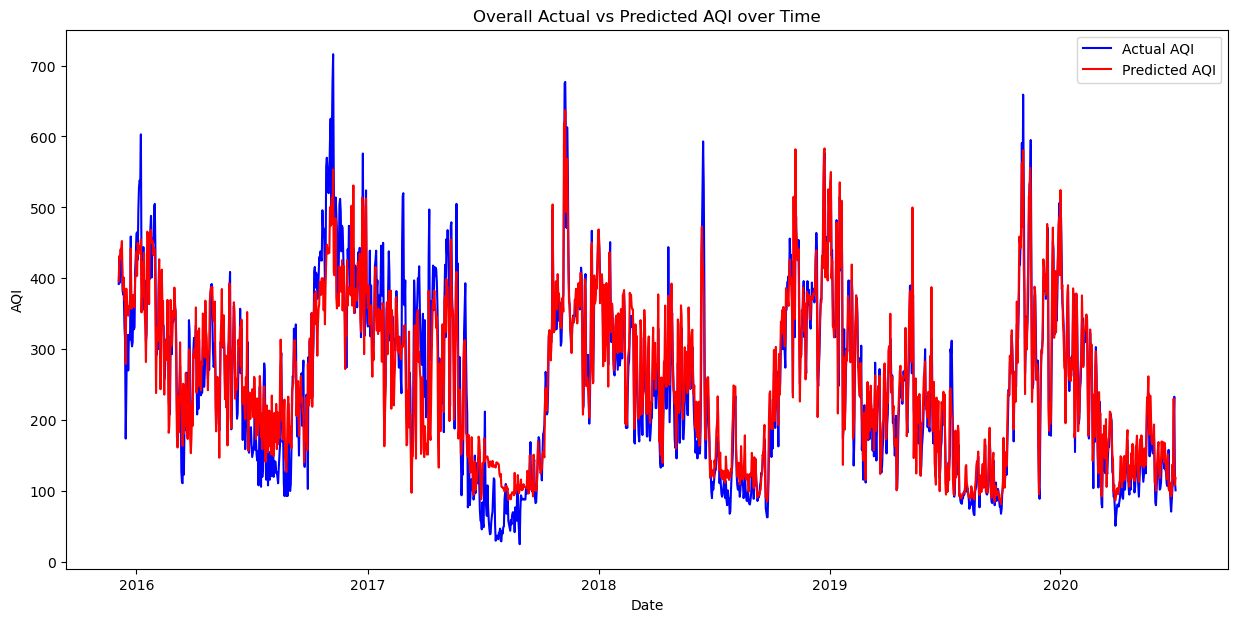

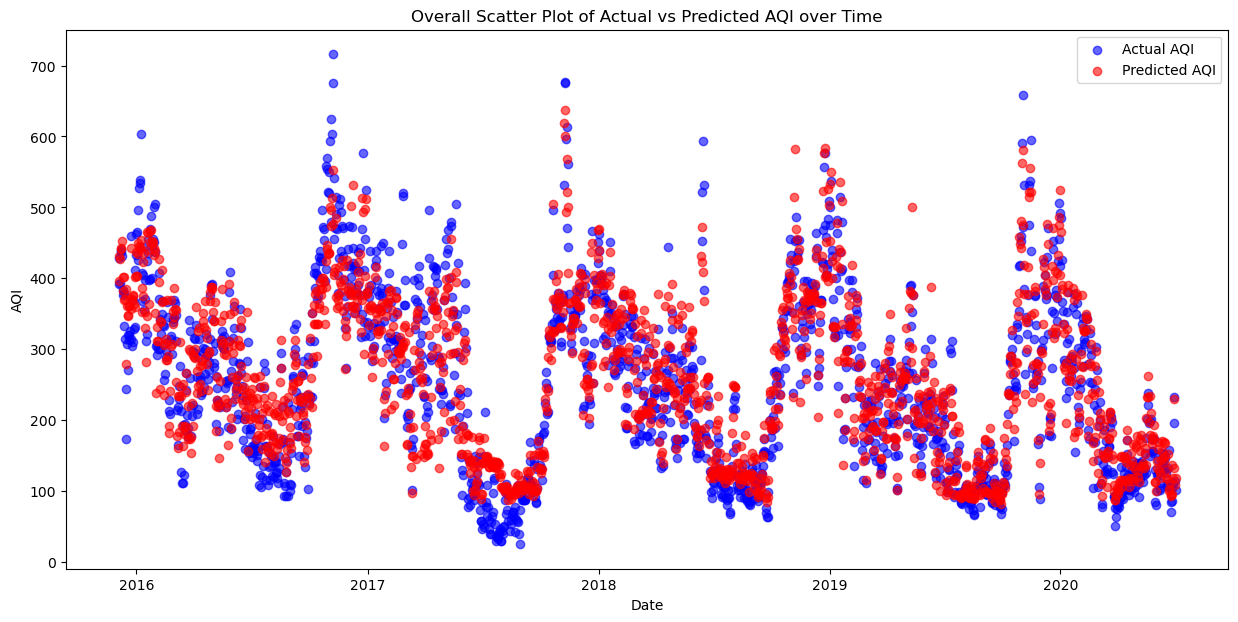

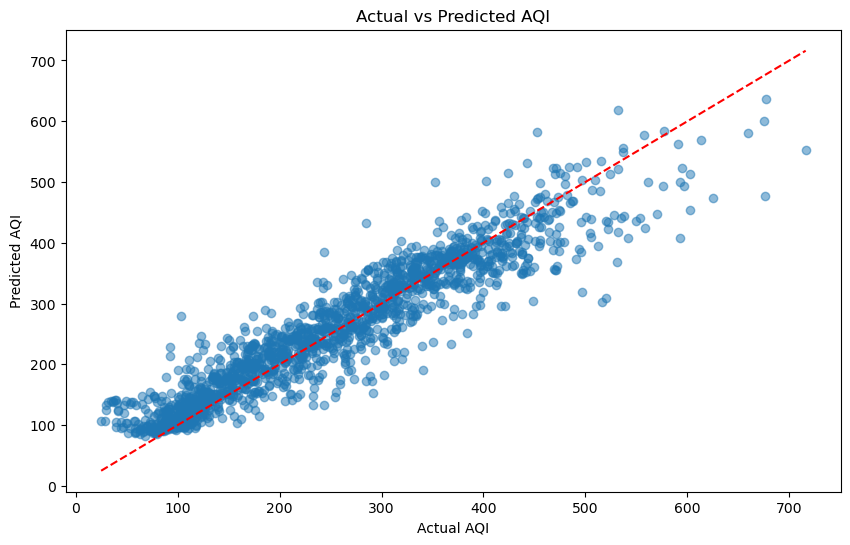

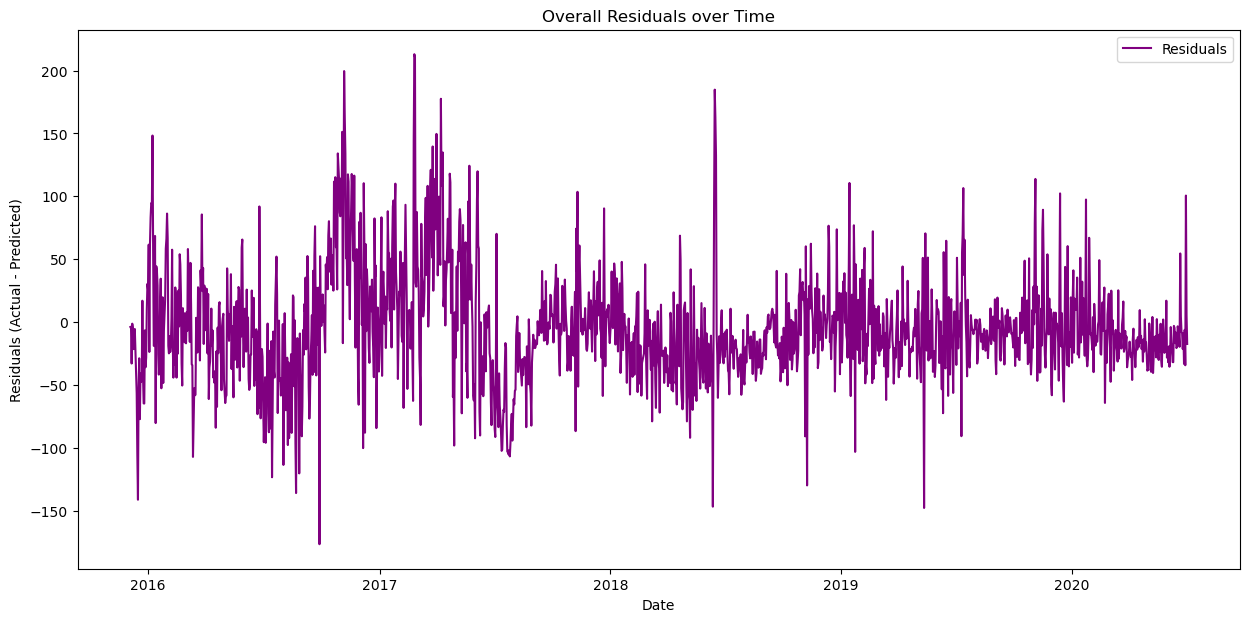

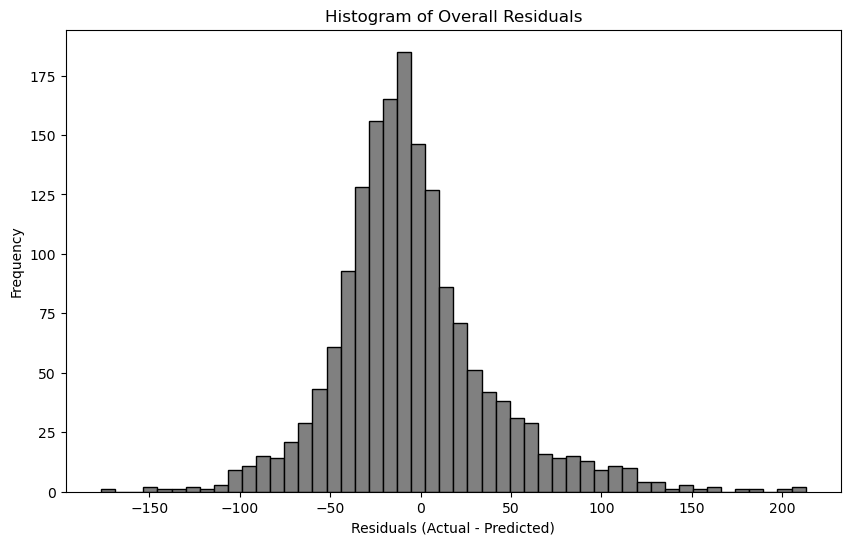

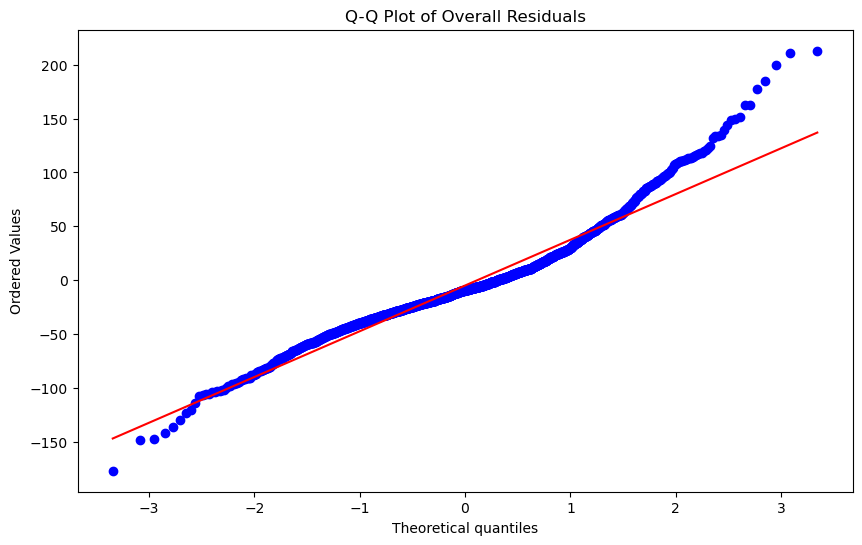

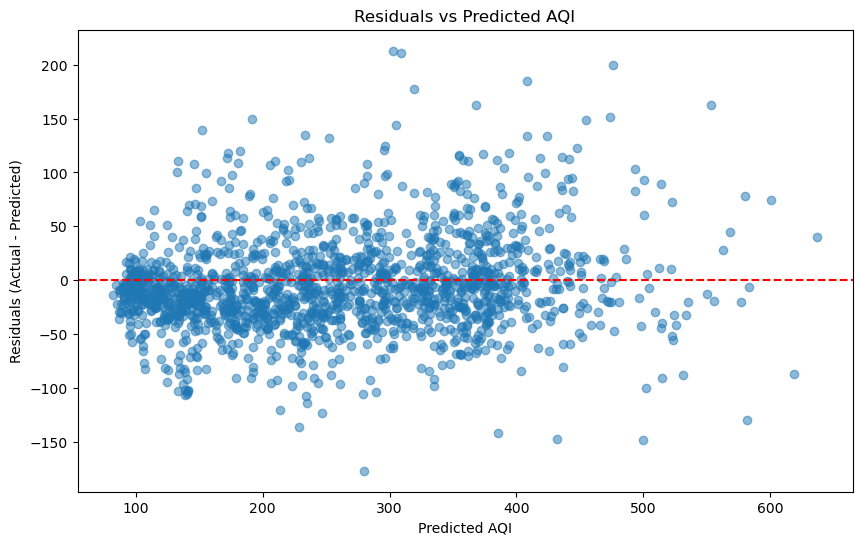

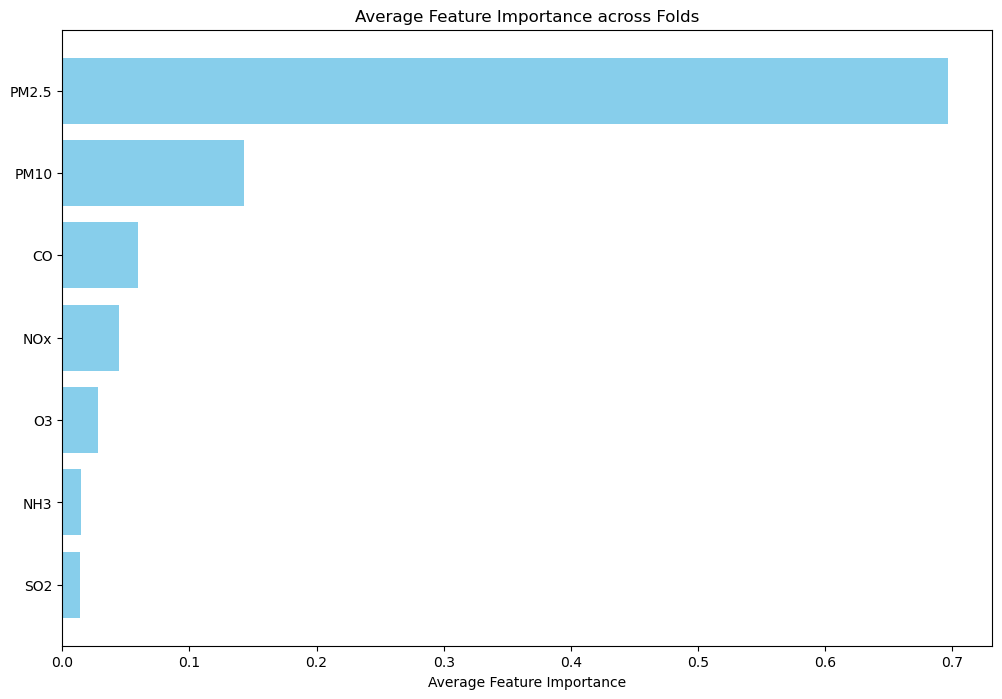

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import for Q-Q plot
import scipy.stats as stats

# Load and preprocess data
df = pd.read_csv(r"I:\My Drive\Data Science\Sri Vipra\Code\Cities Seperated\Delhi_data.csv", parse_dates=['Date'])
df = df.drop(columns=['AQI_Bucket', 'City'])
df = df.interpolate(method='linear')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Separate features and target
X = df.drop(['AQI', 'Date'], axis=1)
feature_names = X.columns  # Save feature names for plotting
X = X.values
y = df['AQI'].values
dates = df['Date'].values  # Extract dates for plotting

# Define TimeSeriesSplit
n_splits = 5  # Adjust based on your data size
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
])


# Define parameter grid for Hyperparametertuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

# Create a dictionary to store metrics across all folds
results = {
    'Fold': [],
    'Best_Params': [],
    'RMSE': [],
    'MSE': [],
    'MAE': [],
    'R2_Score': []
}

# Initialize lists to store actual and predicted values for plotting
all_y_val = []
all_y_pred = []
all_dates_val = []
feature_importances = []
all_residuals = []  # To store residuals for error plots

fold = 1
for train_index, val_index in tscv.split(X):
    print(f"\nGradient Boosting - Fold {fold}")
    X_train_outer, X_val_outer = X[train_index], X[val_index]
    y_train_outer, y_val_outer = y[train_index], y[val_index]
    dates_train_outer, dates_val_outer = dates[train_index], dates[val_index]
    
    # Inner TimeSeriesSplit for hyperparameter tuning
    inner_tscv = TimeSeriesSplit(n_splits=3)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=inner_tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit on the outer training data
    grid_search.fit(X_train_outer, y_train_outer)
    
    # Best model evaluation on the outer validation set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val_outer)
    
    # Collect predictions and actual values
    all_y_val.append(y_val_outer)
    all_y_pred.append(y_pred)
    all_dates_val.append(dates_val_outer)
    
    # Collect feature importances
    feature_importances.append(best_model.named_steps['regressor'].feature_importances_)
    
    # Calculate residuals
    residuals = y_val_outer - y_pred
    all_residuals.append(residuals)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_outer, y_pred))  # RMSE
    mse = mean_squared_error(y_val_outer, y_pred)  # MSE
    mae = mean_absolute_error(y_val_outer, y_pred)  # MAE
    r2 = r2_score(y_val_outer, y_pred)  # R²
    
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation MSE: {mse:.2f}")
    print(f"Validation MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Store results for the current fold
    results['Fold'].append(fold)
    results['Best_Params'].append(grid_search.best_params_)
    results['RMSE'].append(rmse)
    results['MSE'].append(mse)
    results['MAE'].append(mae)
    results['R2_Score'].append(r2)
    
    # Plot actual vs predicted AQI over time for the current fold (Line Plot)
    sorted_indices = np.argsort(dates_val_outer)
    dates_val_sorted = dates_val_outer[sorted_indices]
    y_val_sorted = y_val_outer[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    residuals_sorted = residuals[sorted_indices]
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates_val_sorted, y_val_sorted, label='Actual AQI', color='blue')
    plt.plot(dates_val_sorted, y_pred_sorted, label='Predicted AQI', color='red')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title(f'Actual vs Predicted AQI over Time - Fold {fold}')
    plt.legend()
    plt.show()
    
    # Plot scatter of actual vs predicted AQI over time for the current fold
    plt.figure(figsize=(15, 7))
    plt.scatter(dates_val_outer, y_val_outer, label='Actual AQI', color='blue', alpha=0.6)
    plt.scatter(dates_val_outer, y_pred, label='Predicted AQI', color='red', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title(f'Scatter Plot of Actual vs Predicted AQI over Time - Fold {fold}')
    plt.legend()
    plt.show()
    
    # Plot residuals over time for the current fold
    plt.figure(figsize=(15, 7))
    plt.plot(dates_val_sorted, residuals_sorted, label='Residuals', color='purple')
    plt.xlabel('Date')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residuals over Time - Fold {fold}')
    plt.legend()
    plt.show()
    
    # Plot histogram of residuals for the current fold
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, color='grey', edgecolor='black')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals - Fold {fold}')
    plt.show()
    
    # Q-Q plot of residuals for the current fold
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Residuals - Fold {fold}')
    plt.show()
    
    # Residuals vs Predicted values for the current fold
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted AQI')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residuals vs Predicted AQI - Fold {fold}')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()
    
    fold += 1

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate the average of all metrics across folds
average_metrics = results_df.mean(numeric_only=True)

# Add average metrics as a new row to the DataFrame
average_row = pd.DataFrame([['Average', None, average_metrics['RMSE'], average_metrics['MSE'],
                             average_metrics['MAE'], average_metrics['R2_Score']]], 
                           columns=results_df.columns)

# Append the average row to the results DataFrame
results_df = pd.concat([results_df, average_row], ignore_index=True)

# Concatenate all validation data and residuals
all_y_val = np.concatenate(all_y_val)
all_y_pred = np.concatenate(all_y_pred)
all_dates_val = np.concatenate(all_dates_val)
all_residuals = np.concatenate(all_residuals)

# Sort the concatenated arrays by dates
sorted_indices = np.argsort(all_dates_val)
all_dates_val_sorted = all_dates_val[sorted_indices]
all_y_val_sorted = all_y_val[sorted_indices]
all_y_pred_sorted = all_y_pred[sorted_indices]
all_residuals_sorted = all_residuals[sorted_indices]

# Plot the overall actual vs predicted AQI over time (Line Plot)
plt.figure(figsize=(15, 7))
plt.plot(all_dates_val_sorted, all_y_val_sorted, label='Actual AQI', color='blue')
plt.plot(all_dates_val_sorted, all_y_pred_sorted, label='Predicted AQI', color='red')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Overall Actual vs Predicted AQI over Time')
plt.legend()
plt.show()

# Plot the overall scatter plot of actual vs predicted AQI over time
plt.figure(figsize=(15, 7))
plt.scatter(all_dates_val_sorted, all_y_val_sorted, label='Actual AQI', color='blue', alpha=0.6)
plt.scatter(all_dates_val_sorted, all_y_pred_sorted, label='Predicted AQI', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Overall Scatter Plot of Actual vs Predicted AQI over Time')
plt.legend()
plt.show()

# Plot the overall scatter plot of actual vs predicted AQI
plt.figure(figsize=(10, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.5)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.plot([all_y_val.min(), all_y_val.max()], [all_y_val.min(), all_y_val.max()], 'r--')
plt.show()

# Plot the overall residuals over time
plt.figure(figsize=(15, 7))
plt.plot(all_dates_val_sorted, all_residuals_sorted, label='Residuals', color='purple')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Overall Residuals over Time')
plt.legend()
plt.show()

# Plot histogram of overall residuals
plt.figure(figsize=(10, 6))
plt.hist(all_residuals, bins=50, color='grey', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Overall Residuals')
plt.show()

# Q-Q plot of overall residuals
plt.figure(figsize=(10, 6))
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Overall Residuals')
plt.show()

# Residuals vs Predicted values for overall data
plt.figure(figsize=(10, 6))
plt.scatter(all_y_pred, all_residuals, alpha=0.5)
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted AQI')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Calculate average feature importance across folds
average_importance = np.mean(feature_importances, axis=0)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': average_importance
})

# Sort features by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance across Folds')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [2]:
results_df

,Fold,Best_Params,RMSE,MSE,MAE,R2_Score
0,1,"{'regressor__learning_rate': 0.05, 'regressor_...",49.624371,2462.578232,38.934926,0.794296
1,2,"{'regressor__learning_rate': 0.05, 'regressor_...",62.827365,3947.277751,49.162540,0.830764
2,3,"{'regressor__learning_rate': 0.05, 'regressor_...",37.354256,1395.340456,28.534401,0.891750
3,4,"{'regressor__learning_rate': 0.05, 'regressor_...",32.061834,1027.961173,23.855450,0.917845
4,5,"{'regressor__learning_rate': 0.05, 'regressor_...",26.958858,726.780005,20.763534,0.949874
5,Average,None,41.765337,1911.987523,32.250170,0.876906
